In [436]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [437]:
import os
# path = os.path.dirname(os.getcwd())
path = "../.."
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [438]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [439]:
print("\n...Before preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)


## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [440]:
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

### 2) 세대당가능주차면수

In [441]:
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

### 3) 공가비율

In [442]:
train['공가비율']= train.공가수/train.총세대수 
test['공가비율']= test.공가수/test.총세대수 

### 4) 대형전용면적

In [443]:
level = 85
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [444]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [445]:
# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...After preprocessing
(2577, 38) (936, 37)


- 1차원으로 합치기

In [446]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [447]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
print("\n...After flatten")
print(train_one.shape, test_one.shape)


...After flatten
(414, 30) (147, 29)


In [448]:
set(train_one.columns)-set(['단지코드', '총세대수', '지역', '공가수', '자격유형', '지하철역', '버스정류장', '단지내주차면수',
       '등록차량수', '단지명', '도로명주소', '연면적', '위도', '경도', 'subway_name',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율'])

set()

- 전용면적별세대수 채우기

In [449]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [450]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [451]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [452]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [453]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [454]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [455]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

In [456]:
print("\n...After flatten")
print(train_one.shape, test_one.shape)


...After flatten
(414, 42) (147, 41)


In [458]:
train_one.to_csv("train_one_f.csv",index=False)

### 8) 변수제거

In [459]:
col = ['단지명','도로명주소','subway_name','임대상가']

In [460]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [461]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [462]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [463]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

<AxesSubplot:xlabel='등록차량수-총세대수', ylabel='Density'>

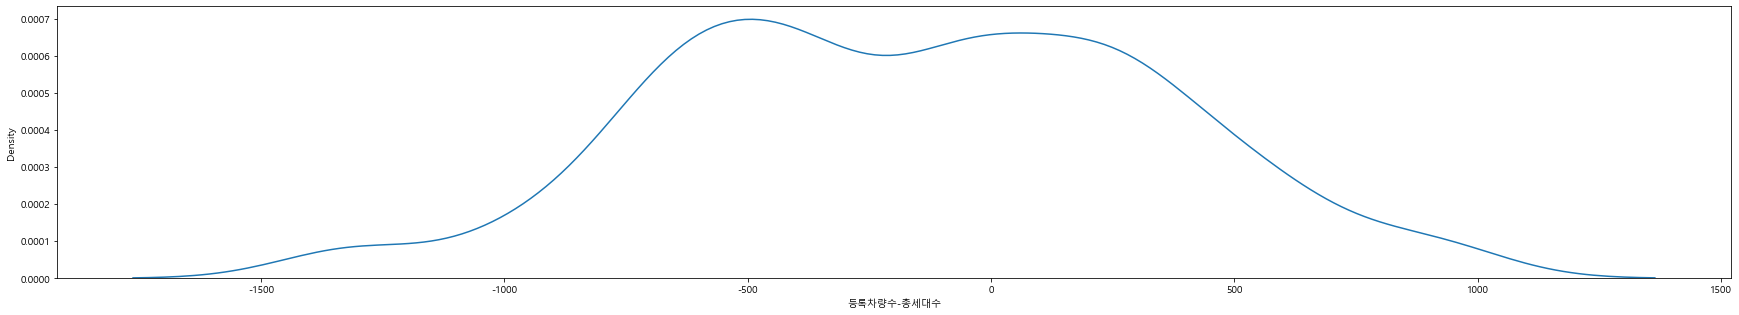

In [464]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

<AxesSubplot:xlabel='지역', ylabel='count'>

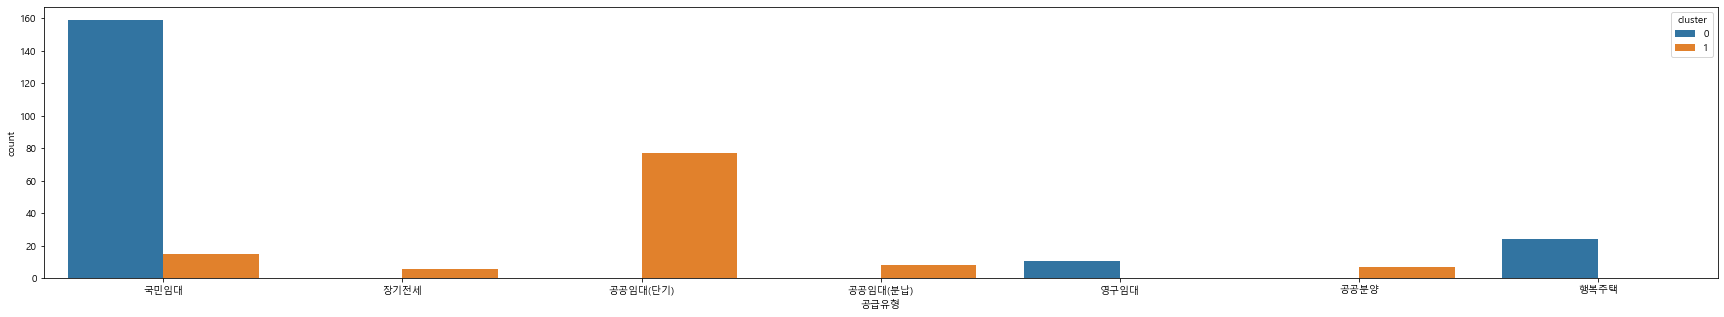

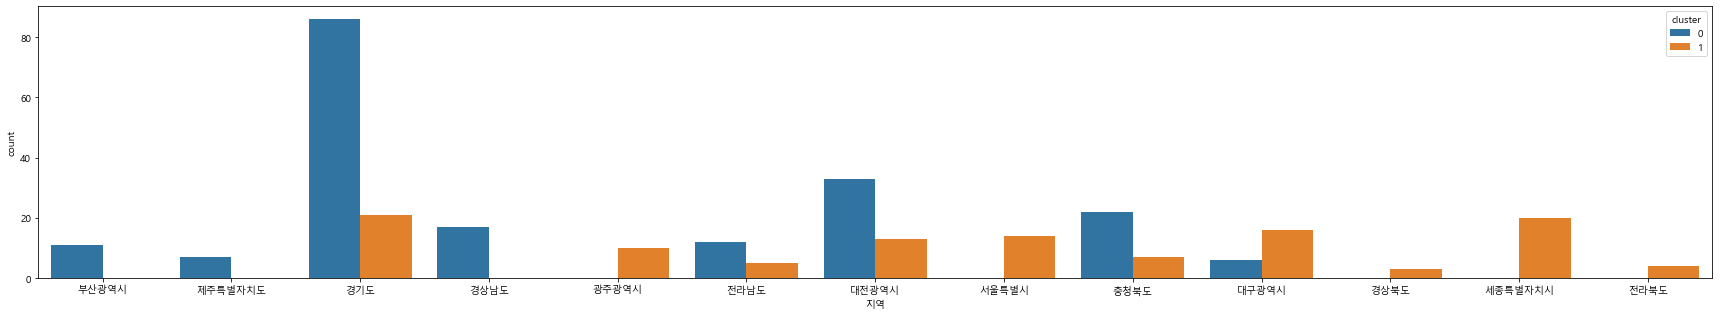

In [89]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

In [465]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도',
             '경기도',
             '부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [466]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [467]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

## 3. 모델링

In [468]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [331]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [332]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) #지역
y = train_down['등록차량수']

In [333]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

MAE :  105.37534703159452


<AxesSubplot:>

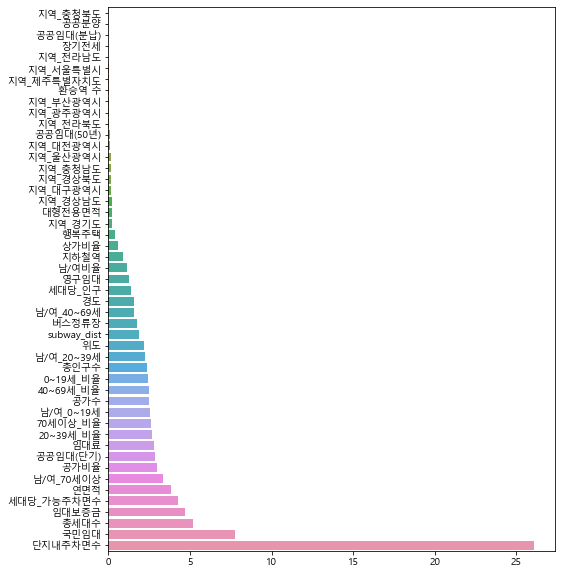

In [334]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

### 2) train/test up

In [335]:
X = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  290.3421818734166


<AxesSubplot:>

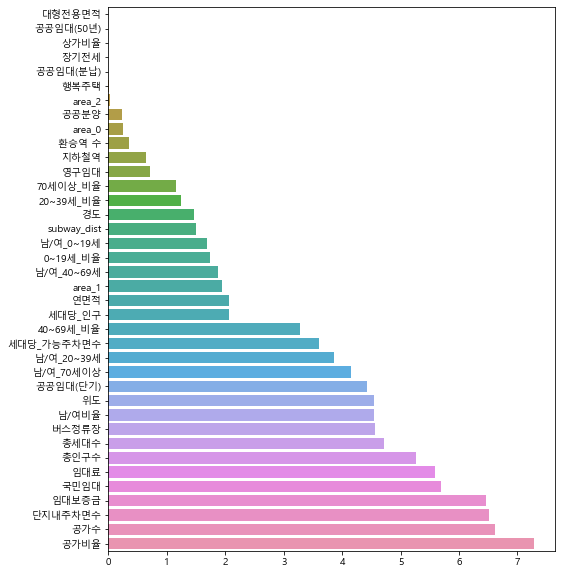

In [336]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

## 4. Final prediction
#### train_down

In [469]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [470]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [471]:
# X_train.to_csv("X_train_f.csv",index=False)

In [472]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

#### train_up

In [539]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적']

In [540]:
set(train_up.columns)-set(test_up.columns)

{'등록차량수'}

In [541]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

cb_up = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

In [542]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

## 5. 기존 score와 비교 및 제출

In [543]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [544]:
sub = submit()
sub.to_csv("result/result.csv",index=False)

In [545]:
def score(mse):
    score = pd.read_csv("result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score



# 51.19024543874576

In [546]:
res1 = score(98)

전체 MAE :  6.359828682016464
큰 영역 MAE :  49.20499032928526
작은 영역 MAE :  3.6637359812630166e-15


In [547]:
res2 = score(96)

전체 MAE :  6.61642628119846
큰 영역 MAE :  51.19024543874576
작은 영역 MAE :  3.064215547965432e-14


In [507]:
res1 = score(98)

전체 MAE :  6.989845325040442
큰 영역 MAE :  54.07932962004971
작은 영역 MAE :  3.6637359812630166e-15


In [508]:
res2 = score(96)

전체 MAE :  5.5470652671766345
큰 영역 MAE :  42.916768119734805
작은 영역 MAE :  3.064215547965432e-14


In [498]:
res1 = score(98)

전체 MAE :  6.4898729132825785
큰 영역 MAE :  50.2111220132915
작은 영역 MAE :  3.6637359812630166e-15


In [499]:
res2 = score(96)

전체 MAE :  6.376584659306089
큰 영역 MAE :  49.33462867989427
작은 영역 MAE :  3.064215547965432e-14


In [490]:
pred2 = pd.DataFrame({'단지코드':test_up.단지코드, "등록차량수":pred_up})
pred2

,단지코드,등록차량수
0,C1128,1250.639209
1,C1332,1389.944143
2,C1563,1735.970199
3,C1794,996.040947
4,C1152,877.157665
5,C2555,1436.584665
6,C2608,1110.974486
7,C1617,1077.191371
8,C1250,1247.842951
9,C2028,1145.174004


## 건드리지 말기

In [480]:
res1 = score(98)

전체 MAE :  6.359828682016464
큰 영역 MAE :  49.20499032928526
작은 영역 MAE :  3.6637359812630166e-15


In [481]:
res2 = score(96)

전체 MAE :  6.61642628119846
큰 영역 MAE :  51.19024543874576
작은 영역 MAE :  3.064215547965432e-14


In [489]:
pred1 = pd.DataFrame({'단지코드':test_down.단지코드, "등록차량수":pred_down})
pred1
# pred1.to_csv("pred_down.csv",index=False)

,단지코드,등록차량수
0,C1072,751.540951
1,C1456,539.409116
2,C1840,533.220234
3,C1640,464.134797
4,C1377,364.187487
...,...,...
123,C2456,241.911953
124,C1266,501.895826
125,C2152,68.167044
126,C1267,340.937514


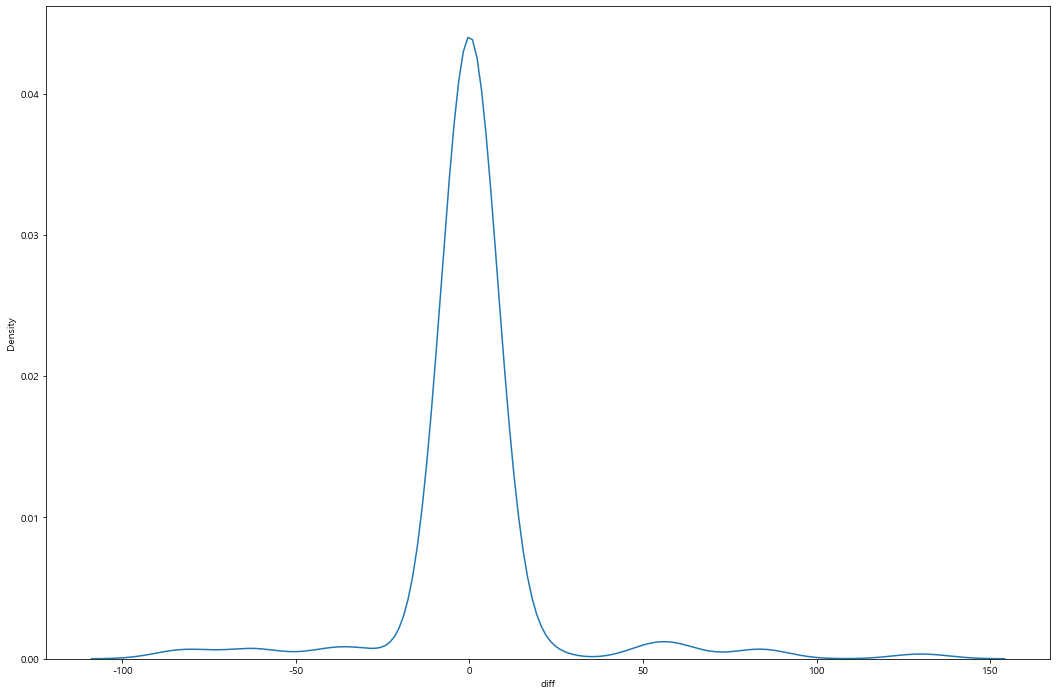

In [242]:
res2['diff']  = res2['num_x']-res2['num_y']
fig, ax = plt.subplots(figsize=(18,12))
sns.kdeplot(res2['diff'])
plt.show()

In [246]:
res2.sort_values('diff')

,code,num_x,num_y,diff
137,C2028,1060.469848,1145.174004,-84.704155
143,C2267,940.641339,1019.841581,-79.200242
128,C1128,1188.382634,1250.639209,-62.256575
129,C1332,1327.919226,1389.944143,-62.024917
136,C1250,1205.940954,1247.842951,-41.901996
...,...,...,...,...
142,C1525,1139.379376,1081.680608,57.698767
130,C1563,1797.687836,1735.970199,61.717637
134,C2608,1193.936851,1110.974486,82.962365
141,C2473,1191.698222,1106.906330,84.791892


In [264]:
res2

,code,num_x,num_y,diff
0,C1072,751.540951,751.540951,0.000000e+00
1,C1456,539.409116,539.409116,0.000000e+00
2,C1840,533.220234,533.220234,0.000000e+00
3,C1640,464.134797,464.134797,5.684342e-14
4,C1377,364.187487,364.187487,5.684342e-14
...,...,...,...,...
142,C1525,1139.379376,1081.680608,5.769877e+01
143,C2267,940.641339,1019.841581,-7.920024e+01
144,C1692,969.004960,965.394890,3.610070e+00
145,C1570,899.031182,935.033363,-3.600218e+01


In [266]:
code_good = res2.loc[(np.abs(res2['diff'])<=10)&(res2.code.isin(test_up.단지코드.unique())),"code"]

In [267]:
code_bad = res2.loc[(np.abs(res2['diff'])>10)&(res2.code.isin(test_up.단지코드.unique())),"code"]

In [364]:
code_bad 

128    C1128
129    C1332
130    C1563
131    C1794
132    C1152
134    C2608
136    C1250
137    C2028
138    C1495
139    C1521
140    C2076
141    C2473
142    C1525
143    C2267
145    C1570
146    C2303
Name: code, dtype: object

In [276]:
test_up.loc[test_up.단지코드.isin(code_good),"지역"].sort_values()

7      경상남도
5     광주광역시
16    대구광역시
Name: 지역, dtype: object

In [277]:
test_up.loc[test_up.단지코드.isin(code_bad),"지역"].sort_values()

10      강원도
0       경기도
1       경기도
2       경기도
6       경기도
8       경기도
14      경기도
15      경기도
18      경기도
9      경상남도
12     경상남도
13    광주광역시
4     부산광역시
3      전라북도
11     전라북도
17     충청북도
Name: 지역, dtype: object

In [ ]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

In [66]:
tmp = pd.merge(res1,res2[['code','num_x']],on='code')
tmp.columns = ['code','98','current','96']